# **Vehicle Detection** 
***
The goal is to develop a pipeline to detect vehicle driving on the road in the given video sequences. Like many other computer vision tasks, feature extraction is required for detecting cars from non-cars.
Histogram of Oriented Gradients (HOG) features extracted from a labeled datasetare used to train a classifier. 
Linear SVM classifier is chosen to perform this classification. Not only HOG features, but we also employed color information as an augmented feature to perform this task.
A preprocessing step is taken into account to normalize and reduce the dimension of the feature vector.


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

## Loading and exploring dataset
The first step is to explore our dataset. We read all **cars** and **non-cars** and store them into positive and negative samples. We also shuffle our samples for the sake of randomness.
After reading the files, total of **8792** positive samples and **8968** negative samples were stored. Since both classes are balanced in terms of numbers, no extra trimming is required.

Total of 8792 positive samples.
Total of 8968 negative samples.


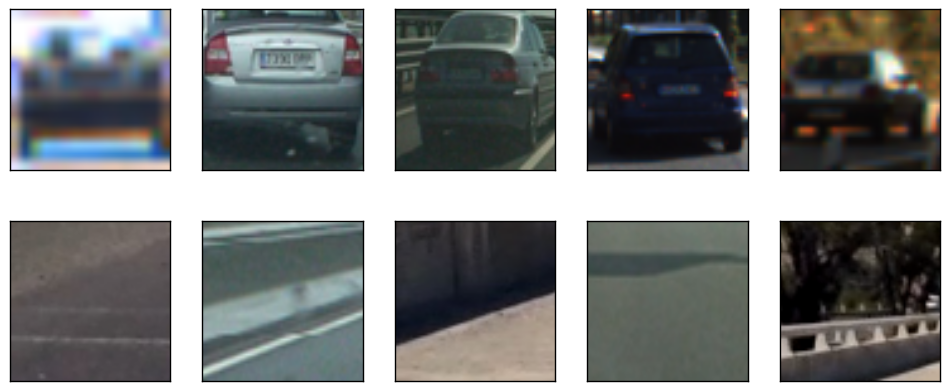

In [2]:
import pickle

data_dir = "."
pos_image_names = []
neg_image_names = []

for pos_path in glob.glob(data_dir+"/vehicles/*/*.png"):
    pos_image_names.append(pos_path)

for neg_path in glob.glob(data_dir+"/non-vehicles/*/*.png"):
    neg_image_names.append(neg_path)

# shuffle both sets
pos_image_names = shuffle(pos_image_names)
neg_image_names = shuffle(neg_image_names)

print("Total of {} positive samples.".format(len(pos_image_names)))
print("Total of {} negative samples.".format(len(neg_image_names)))

fig = plt.figure(figsize=(12, 5))
for i in range(2*5):
    pos_sample = plt.imread(pos_image_names[i])
    neg_sample = plt.imread(neg_image_names[i])

    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(pos_sample)
    ax.axes.get_xaxis().set_visible(False) # hide x tick labels
    ax.axes.get_yaxis().set_visible(False) # hide y tick labels
    if i<5: continue
    ax2 = fig.add_subplot(2, 5, i+1)
    ax2.imshow(neg_sample)
    ax2.axes.get_xaxis().set_visible(False) # hide x tick labels
    ax2.axes.get_yaxis().set_visible(False) # hide y tick labels
        

## Histogram of Oriented Gradients (HOG)
### Color space
After grouping both classes, we used **YCrCb** color space to extract HOG features. We chose this color space by examining different color space and displaying all 3 channels with their HOG features. Comparing to the other spaces such as RGB, we found more variation between three channels of the converted image. We also looked at the output of HOG features to determine which color space has more distinctive power between two classes. 
### HOG parameters
HOG method of `skimage` library is used to detect HOG features and we used the following parameters:
+ orient = 9
+ pix_per_cell = 8
+ cell_per_block = 2

This parameters are chosen by seeing the output of each channels. We found some parameters not so crucial like orientation parameters (i.e. $8 <= \text{orient} <= 10$ is a good choice). 


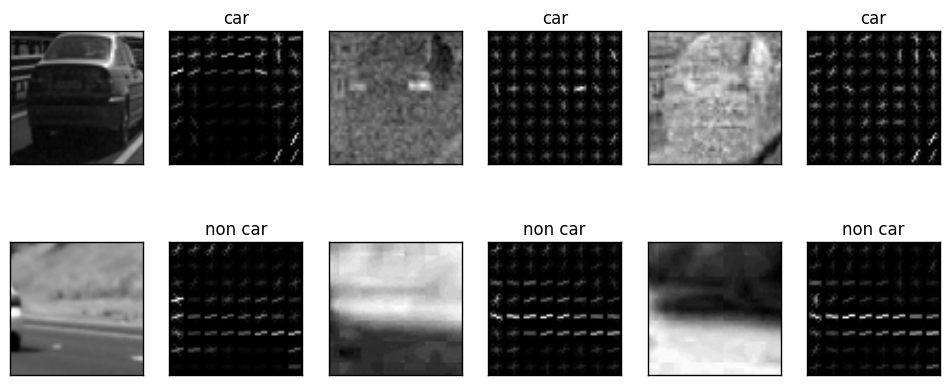

In [3]:
from skimage.feature import hog

orient = 9
pix_per_cell = 8
cell_per_block = 2

# Define a function to return HOG features and visualization
def get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

pos_sample = mpimg.imread(pos_image_names[2])
pos_sample = cv2.cvtColor(pos_sample, cv2.COLOR_RGB2YCrCb)
neg_sample = mpimg.imread(neg_image_names[2])
neg_sample = cv2.cvtColor(neg_sample, cv2.COLOR_RGB2YCrCb)

fig = plt.figure(figsize=(12, 5))
elem = 1
for row, name  in enumerate(['car', 'non car']):
    for ch in range(pos_sample.shape[2]):
        sample = pos_sample if name=='car' else neg_sample
        
        _, hog_img = get_hog_features(sample[:,:,ch], orient, pix_per_cell,
                                      cell_per_block, True, False)

        ax = fig.add_subplot(2, 6, elem)
        ax.imshow(sample[:,:,ch], cmap='gray')
        ax.axes.get_xaxis().set_visible(False) # hide x tick labels
        ax.axes.get_yaxis().set_visible(False) # hide y tick labels
        elem += 1

        ax = fig.add_subplot(2, 6, elem)
        ax.imshow(hog_img, cmap='gray')
        plt.title(name)        
        ax.axes.get_xaxis().set_visible(False) # hide x tick labels
        ax.axes.get_yaxis().set_visible(False) # hide y tick labels
        elem += 1

### Color features
We augment HOG features by adding histogram of color for all three channels. 
We first normalized each sample to a 32x32 patch and applied histogram of 32 bins on them. Then we concatenated both set of features and flatten the results to feed our classifier.
Ultimately, each feature contains total of 8460 elements including:
+ 3168 color elements
+ 5292 HOG elements.

We applied a normalization step to avoid a set of features dominating the response of our classifier. 

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_color_feature(img, spatial_size=(32, 32),
                          hist_bins=32, hist_range=(0, 256)):
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(img, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(img, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    color_feature = np.concatenate((spatial_features, hist_features))
    return color_feature

def extract_colorAndHog_feature(img, color_params, hog_params):
    orient = hog_params['orient']
    pix_per_cell = hog_params['pix_per_cell']
    cell_per_block = hog_params['cell_per_block']
    hog_feature = []
    hog_feature.append(get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block))
    hog_feature.append(get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block))
    hog_feature.append(get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block))
    hog_feature = np.ravel(hog_feature)        
    
    spatial_size = color_params['spatial_size']
    hist_bins = color_params['hist_bins']
    hist_range = color_params['hist_range']
    color_feature = extract_color_feature(img, spatial_size, hist_bins, hist_range)
    
    return color_feature, hog_feature


In [5]:
pos_sample = mpimg.imread(pos_image_names[2])
pos_sample = cv2.cvtColor(pos_sample, cv2.COLOR_RGB2YCrCb)

color_params = {'spatial_size':(32, 32),
                'hist_bins': 32,
                'hist_range': (0, 256)}

hog_params = {'orient': 9,
              'pix_per_cell': 8,
              'cell_per_block': 2}

color_feature, hog_feature = extract_colorAndHog_feature(pos_sample,
                                                         color_params, hog_params)
sample_feature = np.concatenate((color_feature, hog_feature))

print("Total of {0} features including:\n"
      "{1} color features and {2} HOG features.".format(len(sample_feature),
                                                        len(color_feature),
                                                        len(hog_feature)))

Total of 8460 features including:
3168 color features and 5292 HOG features.


In [6]:
# Try to load previously extracted data
pickle_file = './pos_neg_data.p'
try:
    with open(pickle_file, 'rb') as cf:
        pos_neg_data = pickle.load(cf)
    print('Features are loaded!')
    
# Compute features otherwise
except Exception as e:
    print('Invalid or no pickle file found!')
    print('Continue to compute feature set...')

    # extract all positive features
    pos_features = []
    for image_name in pos_image_names:
        sample = mpimg.imread(image_name)
        sample = cv2.cvtColor(sample, cv2.COLOR_RGB2YCrCb)
        color_feature, hog_feature = extract_colorAndHog_feature(sample,
                                                                 color_params, hog_params)
        # append each feature to the list
        pos_features.append(np.concatenate((color_feature, hog_feature)))

    # extract all negative features
    neg_features = []
    for image_name in neg_image_names:
        sample = mpimg.imread(image_name)
        sample = cv2.cvtColor(sample, cv2.COLOR_RGB2YCrCb)
        color_feature, hog_feature = extract_colorAndHog_feature(sample,
                                                                 color_params, hog_params)
        # append each feature to the list
        neg_features.append(np.concatenate((color_feature, hog_feature)))

    # create dictionary of data
    pos_neg_data = {'pos_features': pos_features,
                    'neg_features': neg_features}
                
    with open(pickle_file, 'wb') as cf:
        pickle.dump(pos_neg_data, cf)    
        print('New feature set is saved in {}!'.format(pickle_file))
        
print("{} positive samples!".format(len(pos_neg_data['pos_features'])))
print("{} negative samples!".format(len(pos_neg_data['neg_features'])))


Features are loaded!
8792 positive samples!
8968 negative samples!


In [7]:
# Preprocess features

pos_features = pos_neg_data['pos_features']
neg_features = pos_neg_data['neg_features']

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(pos_features)), np.zeros(len(neg_features))))

# Create an array stack of feature vectors
X = np.vstack((pos_features, neg_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2,
                                                    random_state = rand_state)

print("Train size: {}".format(len(X_train)))
print("Test size: {}".format(len(X_test)))


Train size: 14208
Test size: 3552


## Learning SVM classifier
We chose linear SVM for this classification task. Both car and non-car classes are labeld with `1` and `0` labels respectively. We shuffled and normalized out sample features and fed them to our SVC classifier. 
To avoid overfitting problem, we splited the whole set into training and test group containing 80% training data and 20% test data. 

The test accuracy of our classifier reached 99% accuracy. 


In [11]:
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time() - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
print(round(time.time() - t, 5), 'seconds to predict', n_predict,'labels with SVC')

8.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
SVC predicts:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
0.00122 seconds to predict 10 labels with SVC


In [12]:
from scipy.ndimage.measurements import label

def slide_window(img_shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_params, hog_params):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that sub-window
        color_feature, hog_feature = extract_colorAndHog_feature(test_img,
                                                                 color_params, hog_params)
        features = np.concatenate((color_feature, hog_feature))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0

    return heatmap

def bbox_from_labels(labels):
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)        
    return bbox_list

def non_max_suppress(img_shape, bboxes, threshold):
    heatmap = np.zeros((img_shape[0], img_shape[1])).astype(np.float)
    heat = add_heat(heatmap, bboxes)
    heatmap = apply_threshold(heat, threshold)
    labels = label(heatmap)
    return bbox_from_labels(labels), heat

windows = []
img_shape = (720, 1280)
sizes = [(72, 72), (96,96), (120, 120), (150,150)]
for size in sizes:
    wins = slide_window(img_shape, x_start_stop=[None, None], y_start_stop=[400, 650], 
                        xy_window=size, xy_overlap=(0.5, 0.5))
    windows.append(wins)

windows = [item for sublist in windows for item in sublist]

## Test on images
To test the classifier on images of different sizes, we used a sliding window function to scan all possible sub-windows that might contain vehicle. 
+ For not spending too many cycles, we limited our search area in the range of Y = [400, 650]. 
+ Also we used stride equal to half of each subwindow.  
+ Two different scale is selected to achieve multi-scale detection. 

To reject as many as possible false positives, we performed a grouping strategy for detected boxes. A threshold is used to tune the algorithm. 
Not only it helps discarding false positives, but also it will merge multiple detections into a single bounding box. 
The method is called **`non_max_suppress()`**

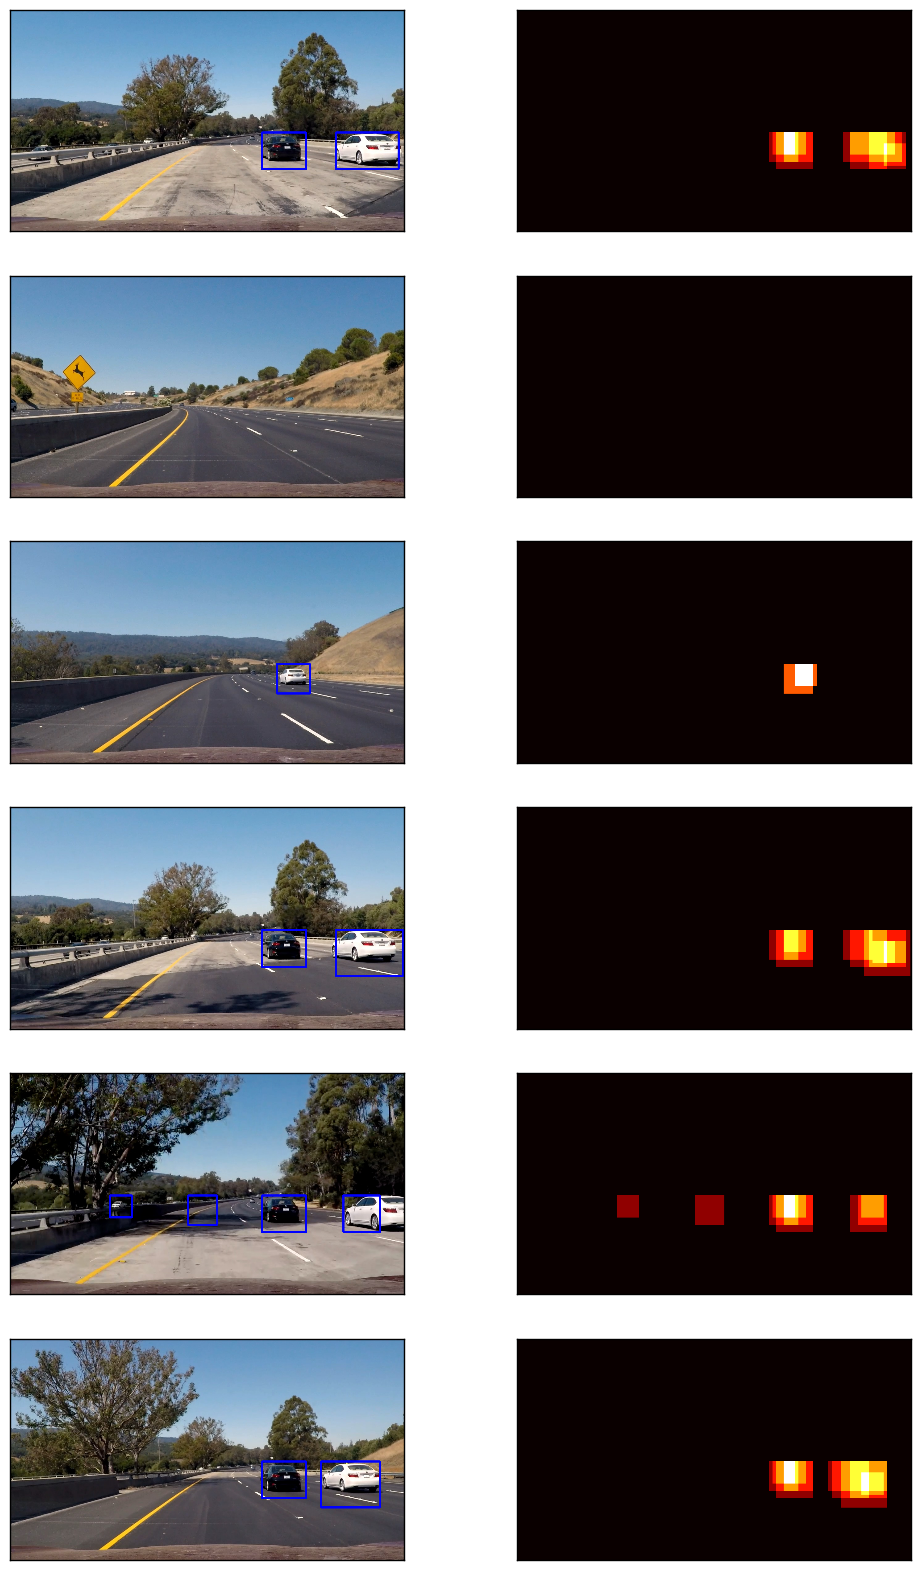

In [24]:
import os
import fnmatch

def process_image(image):
    image = image.astype(np.float32)/255
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_params, hog_params)                       
    return hot_windows

def save_image(filename, image):
    print("saved result in %s" % filename)
    plt.imshow(window_img)
    plt.savefig(filename, format='png')
    
test_dir = os.getcwd() + '/test_images'
output_dir = os.getcwd() + '/output_images'
fig = plt.figure(figsize=(12, 20))
elem = 1
for file in os.listdir(test_dir):
    if not fnmatch.fnmatch(file, "*.jpg"):
        continue
    filename = os.path.join(test_dir, file)
    image = mpimg.imread(filename)
    draw_image = np.copy(image)

    detections = process_image(image)
    detections, heat = non_max_suppress(image.shape, detections, 1)
    window_img = draw_boxes(draw_image, detections, color=(0, 0, 255), thick=6)
    heat *= 255.0 / (heat.max()+0.01)
    
    filename = file.split('.')[0] + "_out.png"
    filename = os.path.join(output_dir, filename)
    
    #save_image(filename, window_img)
    
    ax = fig.add_subplot(6, 2, elem)
    ax.imshow(window_img)
    ax.axes.get_xaxis().set_visible(False) # hide x tick labels
    ax.axes.get_yaxis().set_visible(False) # hide y tick labels
    elem += 1
    ax = fig.add_subplot(6, 2, elem)
    ax.imshow(heat, cmap='hot')
    ax.axes.get_xaxis().set_visible(False) # hide x tick labels
    ax.axes.get_yaxis().set_visible(False) # hide y tick labels
    elem += 1
    


## Test on Videos
Once we are happy with our test on images, we move on to test on a video sequence.
To use temporal consistency from the video sequence, we added temporal window of **5** frames to extend our non max supression technique. So, we accumulated detected boxes in 5 consecutive frames and merge them together. 

`VideoProcessor()` is inspired from [hkorre](https://github.com/hkorre/CarND-Vehicle-Detection/blob/master/notebook.ipynb) implementation for the above purpose.

We stored the result of our algorithm on `project_video.mp4` in a file named `output.mp4`.


In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Inspired from https://github.com/hkorre/CarND-Vehicle-Detection/blob/master/notebook.ipynb
class VideoProcessor:
    def __init__(self):
        self._frame_index = 0
        self._FRAME_AGGREGATE = 5
        self._detection_list_total = None
        self._bbox_list_recent = None
        self._threshold = 3
        
    
    def _aggregate_detections(self, detections_):
        if self._detection_list_total is None:
            self._detection_list_total = detections_
        else:
            self._detection_list_total.extend(detections_)

    def process_frame(self, image):
        # find detections
        detections = process_image(image)

        #detections, _ = non_max_suppress(image.shape, detections, 1)

        # aggregate detections
        self._aggregate_detections(detections)
        
        # increment frame number
        self._frame_index += 1
        
        # if we have enough frames...
        if self._frame_index%self._FRAME_AGGREGATE == 0:
            # get aggregate bboxes
            self._bbox_list_recent, _ = non_max_suppress(image.shape, self._detection_list_total,
                                                         self._threshold)
            # reset the detections
            self._detection_list_total = None 
        # if we have bboxes... 
        if self._bbox_list_recent is not None:
            result = draw_boxes(image, self._bbox_list_recent, color=(0, 0, 255), thick=6)
            return result
        else:
            return image


In [15]:
output_video = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_processor = VideoProcessor()

processed_clip = clip1.fl_image(video_processor.process_frame) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [26:58<00:01,  1.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 26min 38s, sys: 20.6 s, total: 26min 59s
Wall time: 26min 58s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

## Reflections

### Drawbacks and sources of improvement
1. This current algorithm is prone to miss some true positives and detect false positives. We can improve the classification by simply use more samples in the training time. 
2. Data augmentation is one choice to improve the accuracy.
3. Better investigation of different color space as well as interactive threshold finding is helpful
4. Hard negative mining can be applied to reduce the number of false positives.
5. For increasing the frame rate, we can avoid detection on regions where we expect already detected cars.
6. Better tracking approach can be useful.
7. Instead of resizing each subwindow, we can first down-sample our input image and adopt the sliding window search.